# BENG123: Final Project
## Part 1: Reconstruction of the Red Blood Cell (RBC) metabolic model

<font color='red'>**IMPORTANT NOTES:**</font>  
* **The IPYNB files must run from top to bottom without errors. We will run your notebook using the following steps: $$\text{"Kernel}\ \rightarrow\ \text{Restart and Run all"}$$**
* **Make sure you are using the correct versions of packages if you are working outside of JupyterHub
<font color='red'>(masspy==0.1.6, libroadrunner==2.1.3)</font>**
* **Do not leave unneccessary code/comments in the final notebook submission as unorganized code may result in loss of points.**

Be sure to include code (e.g., print statements) where necessary to display steps that match up with the rubric.

**Important Note:** You may use additional code cells as needed as long as the code remains organized, legible, and the notebook is able to run.

### Import Packages

In [1]:
from mass.io.json import load_json_model
from mass import Simulation, strip_time
from mass.visualization import plot_time_profile, plot_phase_portrait
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mass.io import json, sbml
from pathlib import Path

pd.set_option('display.max_columns', None)

## 1. Load models from files
Objective: Import the four individual pathway models that will be integrated into the RBC core model.

In [18]:
# Define the models directory
models_dir = os.getcwd()
models_path = Path(models_dir)

# Verify all required model files are present
required_models = [
    "Glycolysis.json",
    "PentosePhosphatePathway.json",
    "AMPSalvageNetwork.json",
    "Hemoglobin.json",
]

print("=" * 60)
print("VERIFYING MODEL FILES")
print("=" * 60)
for model_file in required_models:
    file_path = models_path / model_file
    status = "✓ FOUND" if file_path.exists() else "✗ MISSING"
    print(f"{status}: {model_file}")
print("=" * 60)

VERIFYING MODEL FILES
✓ FOUND: Glycolysis.json
✓ FOUND: PentosePhosphatePathway.json
✓ FOUND: AMPSalvageNetwork.json
✓ FOUND: Hemoglobin.json


In [19]:
print(models_dir)

/Users/nick/Desktop/GitHub/RBC Simulations/models


In [3]:
# Load individual pathway models
glycolysis = load_json_model(models_dir + "/Glycolysis.json")
ppp = load_json_model(models_dir + "/PentosePhosphatePathway.json")
ampsn = load_json_model(models_dir + "/AMPSalvageNetwork.json")
hemoglobin = load_json_model(models_dir + "/Hemoglobin.json")

# Display summary of loaded models
print("\n" + "=" * 60)
print("INDIVIDUAL PATHWAY MODELS LOADED")
print("=" * 60)
models_summary = {
    'Model': ['Glycolysis', 'Pentose Phosphate Pathway', 'AMP Salvage Network', 'Hemoglobin'],
    'Reactions': [len(glycolysis.reactions), len(ppp.reactions), len(ampsn.reactions), len(hemoglobin.reactions)],
    'Metabolites': [len(glycolysis.metabolites), len(ppp.metabolites), len(ampsn.metabolites), len(hemoglobin.metabolites)]
}
print(pd.DataFrame(models_summary).to_string(index=False))
print("=" * 60)


INDIVIDUAL PATHWAY MODELS LOADED
                    Model  Reactions  Metabolites
               Glycolysis         21           20
Pentose Phosphate Pathway         17           17
      AMP Salvage Network         19           15
               Hemoglobin          8           13


## 2. Integrate pathways and hemoglobin to create RBC model
Objective: Merge the four individual pathway models into a single integrated RBC metabolic network.


##### Step 2a: Initial Merge

In [4]:
# Create a copy of glycolysis as the base model
RBC = glycolysis.copy()

# Sequentially merge the other three pathway models
# Note: merge() will warn about duplicate reactions (these are shared boundaries)
RBC.merge(ppp, inplace=True)
RBC.merge(ampsn, inplace=True)
RBC.merge(hemoglobin, inplace=True)

print("\n" + "=" * 60)
print("INITIAL MERGE COMPLETE")
print("=" * 60)
print(f"Total Reactions: {len(RBC.reactions)}")
print(f"Total Metabolites: {len(RBC.metabolites)}")
print(f"Total Compartments: {len(RBC.compartments)}")
print("=" * 60)

Ignoring reaction 'SK_h_c' since it already exists.
Ignoring reaction 'SK_h2o_c' since it already exists.
Ignoring reaction 'ATPM' since it already exists.
Ignoring reaction 'SK_amp_c' since it already exists.
Ignoring reaction 'SK_h_c' since it already exists.
Ignoring reaction 'SK_h2o_c' since it already exists.



INITIAL MERGE COMPLETE
Total Reactions: 59
Total Metabolites: 48
Total Compartments: 1


#### Step 2b: Removal of Redudant Boundary Conditions

In [5]:
# Remove internal boundary reactions that are no longer needed in the integrated model
# These reactions were necessary for isolated pathway models but create redundancy
# when pathways are connected

boundary_reactions_to_remove = [
    "SK_g6p_c",   # G6P sink - G6P now flows between Glycolysis and PPP
    "DM_f6p_c",   # F6P demand - F6P is shared between Glycolysis and PPP
    "DM_g3p_c",   # G3P demand - G3P flows within integrated system
    "DM_r5p_c",   # R5P demand - R5P is internal to integrated network
    "DM_amp_c",   # AMP demand - AMP cycles through AMP Salvage Network
    "SK_amp_c"    # AMP sink - AMP is now internally balanced
]

# Filter to only remove reactions that exist in the model
reactions_in_model = [r.id for r in RBC.boundary]
to_remove = [r for r in RBC.boundary if r.id in boundary_reactions_to_remove]

print("\n" + "=" * 60)
print("REMOVING REDUNDANT BOUNDARY REACTIONS")
print("=" * 60)
print(f"Boundary reactions before removal: {len(RBC.boundary)}")
for rxn in to_remove:
    print(f"  - Removing: {rxn.id}")
    
RBC.remove_reactions(to_remove)

# Remove associated boundary conditions
boundary_metabolites_to_remove = ["g6p_b", "f6p_b", "g3p_b", "r5p_b", "amp_b"]
RBC.remove_boundary_conditions(boundary_metabolites_to_remove)

print(f"Boundary reactions after removal: {len(RBC.boundary)}")
print("=" * 60)


REMOVING REDUNDANT BOUNDARY REACTIONS
Boundary reactions before removal: 19
  - Removing: DM_amp_c
  - Removing: SK_amp_c
  - Removing: SK_g6p_c
  - Removing: DM_f6p_c
  - Removing: DM_g3p_c
  - Removing: DM_r5p_c
Boundary reactions after removal: 13


### Step 2c: Modification of PRPPS Reaction Stoichiometry

In [6]:
# Adjust PRPPS reaction to reflect proper ATP hydrolysis in integrated network
# In the complete RBC model, PRPPS produces AMP + 2 ADP from ATP
# This reflects the actual biochemistry when all pathways work together

print("\n" + "=" * 60)
print("MODIFYING PRPPS REACTION STOICHIOMETRY")
print("=" * 60)

# Note: Reactants have negative coefficients, products have positive coefficients
RBC.reactions.PRPPS.subtract_metabolites({
    RBC.metabolites.atp_c: -1,   # Remove 1 ATP as reactant
    RBC.metabolites.adp_c: 2     # Add 2 ADP as products (net change)
})
RBC.reactions.PRPPS.add_metabolites({
    RBC.metabolites.amp_c: 1     # Add 1 AMP as product
})

print("PRPPS reaction adjusted for integrated network")
print("=" * 60)


MODIFYING PRPPS REACTION STOICHIOMETRY
PRPPS reaction adjusted for integrated network


### Step 2d: Display Final Model

In [7]:
# Set model ID and display final integrated model structure
RBC.id = "RBC_core"

print("\n" + "=" * 80)
print("FINAL INTEGRATED RBC CORE MODEL")
print("=" * 80)
print(f"Model ID: {RBC.id}")
print(f"Total Reactions: {len(RBC.reactions)}")
print(f"Total Metabolites: {len(RBC.metabolites)}")
print(f"Total Compartments: {len(RBC.compartments)}")
#print(f"Matrix Rank: {RBC.stoichiometric_matrix.matrix_rank}")
print(f"Stoichiometric Matrix: {RBC.stoichiometric_matrix.shape[0]} × {RBC.stoichiometric_matrix.shape[1]}")
#print("\nCompartments:", ", ".join([comp.name for comp in RBC.compartments]))
print("\nBoundary Reactions (remaining):")
for rxn in RBC.boundary:
    print(f"  - {rxn.id}")
print("=" * 80)

# Display the MassModel object (provides detailed summary)
display(RBC)


FINAL INTEGRATED RBC CORE MODEL
Model ID: RBC_core
Total Reactions: 53
Total Metabolites: 48
Total Compartments: 1
Stoichiometric Matrix: 48 × 53

Boundary Reactions (remaining):
  - SK_pyr_c
  - SK_lac__L_c
  - SK_glc__D_c
  - SK_h_c
  - SK_h2o_c
  - SK_co2_c
  - SK_adn_c
  - SK_ade_c
  - SK_ins_c
  - SK_hxan_c
  - SK_nh3_c
  - SK_pi_c
  - SK_o2_c


Name,RBC_core
Memory address,0x016b0c0160
Stoichiometric Matrix,48x53
Matrix Rank,44
Number of metabolites,48
Initial conditions defined,48/48
Number of reactions,53
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


## 3. Define the Steady State
Objective: Calculate steady-state fluxes, equilibrium constants (Keq), and PERCs for all reactions.


### Step 3a: Load Minspan Pathways and Define Independent Fluxes

In [8]:
print("\n" + "=" * 60)
print("DEFINING STEADY STATE")
print("=" * 60)

# Load the minspan pathways matrix (basis vectors for flux space)
minspan_pathways = pd.read_csv(models_dir + "/minspan_pathways.csv", index_col=0)
minspan_pathways_array = minspan_pathways.values

# Verify dimensions match
print(f"Minspan pathways shape: {minspan_pathways_array.shape}")
print(f"Model reactions: {len(RBC.reactions)}")
print(f"Dimension match: {minspan_pathways_array.shape[1] == len(RBC.reactions)}")
print()

# Define independent fluxes (experimentally measured or physiologically constrained)
# Units: mmol/(L RBC * hour)
independent_fluxes = {
    RBC.reactions.SK_glc__D_c: 1.12,      # Glucose uptake rate
    RBC.reactions.DM_nadh: 0.2 * 1.12,    # NADH demand (20% of glucose uptake)
    RBC.reactions.GSHR: 0.42,             # Glutathione reductase flux
    RBC.reactions.SK_ade_c: -0.014,       # Adenine sink (negative = production)
    RBC.reactions.ADA: 0.01,              # Adenosine deaminase flux
    RBC.reactions.SK_adn_c: -0.01,        # Adenosine sink
    RBC.reactions.ADNK1: 0.12,            # Adenosine kinase flux
    RBC.reactions.SK_hxan_c: 0.097,       # Hypoxanthine sink
    RBC.reactions.DPGM: 0.441             # 2,3-DPG mutase flux
}

print("Independent fluxes defined:")
for rxn, flux in independent_fluxes.items():
    print(f"  {rxn.id}: {flux:.3f} mmol/(L RBC * hr)")
print("=" * 60)


DEFINING STEADY STATE
Minspan pathways shape: (9, 53)
Model reactions: 53
Dimension match: True

Independent fluxes defined:
  SK_glc__D_c: 1.120 mmol/(L RBC * hr)
  DM_nadh: 0.224 mmol/(L RBC * hr)
  GSHR: 0.420 mmol/(L RBC * hr)
  SK_ade_c: -0.014 mmol/(L RBC * hr)
  ADA: 0.010 mmol/(L RBC * hr)
  SK_adn_c: -0.010 mmol/(L RBC * hr)
  ADNK1: 0.120 mmol/(L RBC * hr)
  SK_hxan_c: 0.097 mmol/(L RBC * hr)
  DPGM: 0.441 mmol/(L RBC * hr)


### Step 3b: Compute Steady-State Fluxes


In [9]:
# Calculate steady-state flux distribution using minspan pathways and constraints
print("\n" + "=" * 60)
print("COMPUTING STEADY-STATE FLUXES")
print("=" * 60)

ssfluxes = RBC.compute_steady_state_fluxes(
    minspan_pathways_array,
    independent_fluxes,
    update_reactions=True
)

print("✓ Steady-state fluxes computed successfully")
print(f"  Number of reactions with defined fluxes: {len(ssfluxes)}")
print("=" * 60)


COMPUTING STEADY-STATE FLUXES
✓ Steady-state fluxes computed successfully
  Number of reactions with defined fluxes: 53


### Step 3c: Calculate PERCs (Parameter Elasticity Response Coefficients)

In [10]:
# Calculate PERCs for all non-hemoglobin/ADK1 reactions
# PERCs quantify the sensitivity of reaction rates to parameter changes
print("\n" + "=" * 60)
print("CALCULATING PERCs")
print("=" * 60)

# Exclude ADK1 and hemoglobin reactions from PERC calculation
reactions_for_perc = {
    r: flux for r, flux in RBC.steady_state_fluxes.items()
    if r.id not in ["ADK1", "SK_o2_c", "HBDPG", "HBO1", "HBO2", "HBO3", "HBO4"]
}

percs = RBC.calculate_PERCs(
    fluxes=reactions_for_perc,
    update_reactions=True
)

print(f"✓ PERCs calculated for {len(reactions_for_perc)} reactions")
print("=" * 60)


CALCULATING PERCs
✓ PERCs calculated for 46 reactions


### Step 3d: Define Rate Constants for Hemoglobin Reactions


In [11]:
# Manually set forward rate constants for hemoglobin oxygen-binding reactions
# These reactions follow different kinetics than metabolic reactions
print("\n" + "=" * 60)
print("DEFINING HEMOGLOBIN RATE CONSTANTS")
print("=" * 60)

hemoglobin_rate_constants = {
    "kf_SK_o2_c": 509726,
    "kf_HBDPG": 519613,
    "kf_HBO1": 506935,
    "kf_HBO2": 511077,
    "kf_HBO3": 509243,
    "kf_HBO4": 501595
}

RBC.update_parameters(hemoglobin_rate_constants)

for param, value in hemoglobin_rate_constants.items():
    print(f"  {param}: {value:,.0f}")
print("=" * 60)


DEFINING HEMOGLOBIN RATE CONSTANTS
  kf_SK_o2_c: 509,726
  kf_HBDPG: 519,613
  kf_HBO1: 506,935
  kf_HBO2: 511,077
  kf_HBO3: 509,243
  kf_HBO4: 501,595


### Step 3e: Create Organized DataFrame of Steady-State Parameters

In [12]:
# Compile steady-state flux, Keq, and kf values into organized DataFrame
print("\n" + "=" * 60)
print("STEADY-STATE PARAMETERS SUMMARY")
print("=" * 60)

df_steady_state = pd.DataFrame([
    [reaction.steady_state_flux for reaction in RBC.reactions],
    [reaction.Keq for reaction in RBC.reactions],
    [reaction.kf for reaction in RBC.reactions]
], 
    index=[r"$\mathbf{v}_{\mathrm{ss}}$ (mmol/L/hr)", r"$K_{eq}$", r"$k_{f}$ (1/hr)"],
    columns=[reaction.id for reaction in RBC.reactions]
)

# Display full DataFrame
print("\nComplete Steady-State Parameters:")
print("=" * 80)
display(df_steady_state)
print("=" * 80)

# Display summary statistics
print("\nSummary Statistics:")
print("-" * 80)
print(df_steady_state.T.describe())
print("=" * 80)


STEADY-STATE PARAMETERS SUMMARY

Complete Steady-State Parameters:


,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,LDH_L,ADK1,SK_pyr_c,SK_lac__L_c,ATPM,DM_nadh,SK_glc__D_c,SK_h_c,SK_h2o_c,G6PDH2r,PGL,GND,RPE,RPI,TKT1,TKT2,TALA,GTHOr,GSHR,SK_co2_c,ADNK1,NTD7,AMPDA,NTD11,ADA,PUNP5,PPM,PRPPS,ADPT,SK_adn_c,SK_ade_c,SK_ins_c,SK_hxan_c,SK_nh3_c,SK_pi_c,DPGM,DPGase,HBO1,HBO2,HBO3,HBO4,HBDPG,SK_o2_c
$\mathbf{v}_{\mathrm{ss}}$ (mmol/L/hr),1.120000,0.910000,1.105333,1.105333,1.105333,2.308333,1.867333e+00,2.308333,2.308333,2.308333,2.084333,-0.014,0.224000,2.084333,2.243333,0.22400,1.12,3.596333,-0.317,0.210000,0.210000,0.210000,0.195333,0.014667,0.097667,0.097667,0.097667,0.420000,0.420000,0.21,0.12,0.120000,0.014000,0.014,0.010000,0.097000,0.097000,0.014000,0.014,-0.01,-0.014,-0.073,0.097,0.024,0.0,4.410000e-01,0.441000,0.0000,0.0000,0.000,0.00,0.00,0.0
$K_{eq}$,850.000000,0.410000,310.000000,0.082000,0.057143,0.017900,1.800000e+03,0.147059,1.694920,363000.000000,26300.000000,1.650,1.000000,1.000000,inf,inf,inf,1.000000,1.000,1000.000000,1000.000000,1000.000000,3.000000,2.570000,1.200000,10.300000,1.050000,100.000000,2.000000,1.00,inf,inf,inf,inf,inf,0.090000,13.300000,inf,inf,1.00,1.000,1.000,1.000,1.000,1.0,2.300000e+06,inf,41.8352,73.2115,177.799,1289.92,0.25,1.0
$k_{f}$ (1/hr),0.700007,2961.111111,34.905621,2797.448560,33.905831,3479.760194,1.061655e+06,5017.110253,1817.545110,468.247016,1150.285243,100000.000,744.186047,5.789815,1.402083,7.44186,1.12,133792.162698,100000.000,21864.589249,122.323112,29287.807474,22392.051968,2021.057749,2338.069643,1600.141028,1237.362642,53.329812,0.041257,100000.00,62.50,1.383635,0.161424,1.400,8.333333,83.142857,1.642747,0.690668,2800.000,100000.00,100000.000,100000.000,100000.000,100000.000,100000.0,1.824937e+03,0.142258,506935.0000,511077.0000,509243.000,501595.00,519613.00,509726.0



Summary Statistics:
--------------------------------------------------------------------------------
       $\mathbf{v}_{\mathrm{ss}}$ (mmol/L/hr)    $K_{eq}$  $k_{f}$ (1/hr)
count                               53.000000     53.0000    5.300000e+01
mean                                 0.590208         inf    9.920487e+04
std                                  0.890611         NaN    2.091308e+05
min                                 -0.317000      0.0179    4.125737e-02
25%                                  0.014000      1.0000    3.390583e+01
50%                                  0.120000     10.3000    2.021058e+03
75%                                  1.105333  26300.0000    1.000000e+05
max                                  3.596333         inf    1.061655e+06


### 4. Graphically verify the steady state
Objective: Simulate the model over time to confirm it reaches and maintains steady state.



GRAPHICAL STEADY-STATE VERIFICATION
Simulation time: 0 to 1000.0 hours
Finding steady state...
✓ Steady state found
Running simulation...
✓ Simulation complete

Generating concentration time profiles...


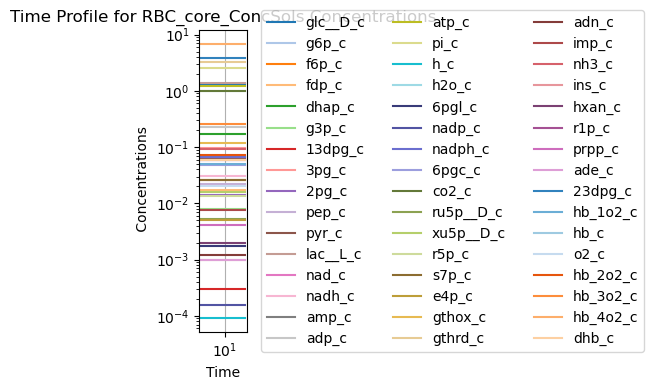

VERIFICATION: All metabolite concentrations reach steady state
Flat lines in the plot indicate steady-state has been achieved


In [13]:
print("\n" + "=" * 60)
print("GRAPHICAL STEADY-STATE VERIFICATION")
print("=" * 60)

# Define simulation time window
t0, tf = 0, 1e3  # Simulate from 0 to 1000 hours
print(f"Simulation time: {t0} to {tf} hours")

# Create simulation object
sim = Simulation(RBC)

# Find steady state using simulation strategy
print("Finding steady state...")
sim.find_steady_state(RBC, strategy="simulate", update_values=True)
print("✓ Steady state found")

# Run simulation
print("Running simulation...")
conc_sol, flux_sol = sim.simulate(RBC, time=(t0, tf))
print("✓ Simulation complete")

# Display time profile plot
print("\nGenerating concentration time profiles...")
conc_sol.view_time_profile()
plt.tight_layout()
plt.show()

print("=" * 60)
print("VERIFICATION: All metabolite concentrations reach steady state")
print("Flat lines in the plot indicate steady-state has been achieved")
print("=" * 60)

### Export Model

Export your RBC model to the `models` directory.

In [14]:
print("\n" + "=" * 60)
print("EXPORTING RBC CORE MODEL")
print("=" * 60)

# Save the integrated RBC model to JSON format
output_filename = RBC.id + ".json"
json.save_json_model(mass_model=RBC, filename=output_filename)

print(f"✓ Model saved as: {output_filename}")
print(f"  Location: {os.path.join(models_dir, output_filename)}")
print("=" * 60)


EXPORTING RBC CORE MODEL
✓ Model saved as: RBC_core.json
  Location: /Users/nick/Desktop/GitHub/RBC Simulations/models/RBC_core.json


## Final Summary

In [15]:
print("\n" + "=" * 80)
print("PART 1 COMPLETION SUMMARY")
print("=" * 80)
print("✓ Item 1: Individual pathway models loaded successfully")
print("✓ Item 2: RBC core model assembled with correct integration")
print("✓ Item 3: Steady-state parameters calculated and displayed")
print("✓ Item 4: Graphical verification shows stable steady state")
print("\n" + "Model Statistics:")
print(f"  Total Reactions: {len(RBC.reactions)}")
print(f"  Total Metabolites: {len(RBC.metabolites)}")
print(f"  Boundary Reactions: {len(RBC.boundary)}")
print(f"  Model ID: {RBC.id}")
print("=" * 80)
print("READY FOR PART 2: ENZYME MODULE INTEGRATION")
print("=" * 80)


PART 1 COMPLETION SUMMARY
✓ Item 1: Individual pathway models loaded successfully
✓ Item 2: RBC core model assembled with correct integration
✓ Item 3: Steady-state parameters calculated and displayed
✓ Item 4: Graphical verification shows stable steady state

Model Statistics:
  Total Reactions: 53
  Total Metabolites: 48
  Boundary Reactions: 13
  Model ID: RBC_core
READY FOR PART 2: ENZYME MODULE INTEGRATION
